See here: https://github.com/fchollet/keras/issues/1061

/Users/davidcottrell/anaconda/envs/35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


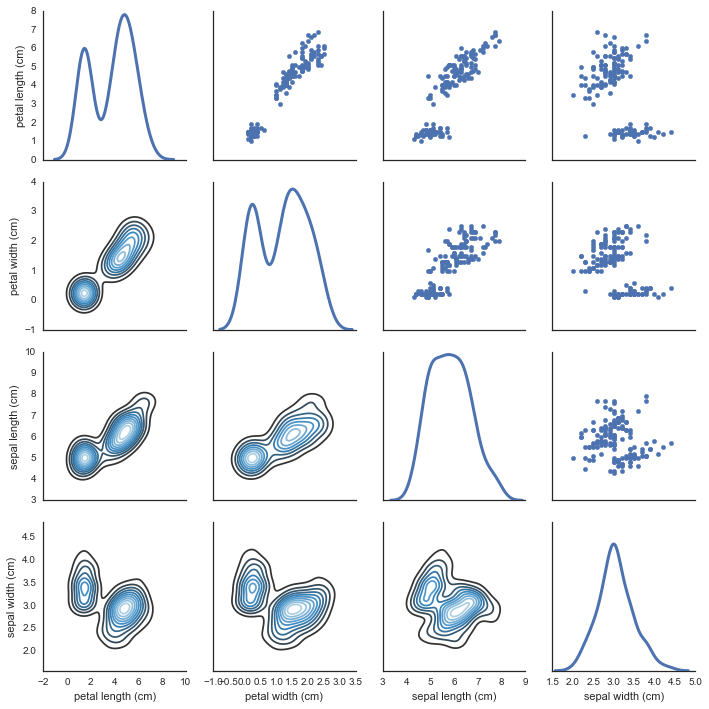

In [2]:
### load data
from imp import reload
import site; site.addsitedir('..')
import mylib.data as md
reload(md)

df, dfd = md.iris()

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [16]:
"""
See here: https://github.com/fchollet/keras/issues/1061
"""
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD

### load data
from imp import reload
import site; site.addsitedir('..')
import mylib.data as md
reload(md)

df, dfd = md.iris()

y_cols = ['petal length (cm)']
x_cols = [x for x in dfd.columns if x not in y_cols]

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfd[x_cols].values,
        dfd[y_cols].values, test_size=0.1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Layer
from keras.optimizers import SGD
from theano import tensor as T
import theano

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the
    target data (y). The first M*D features are treated as means of y, the next M features as
    standard devs and the last M features as mixture components of the GMM.
    """
    def __init__(self, M, D, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M # i.e. number of Gaussian components
        self.D = D # i.e. y.shape[1]
        print("init: shape is {} {}".format(M, D))

    def get_output(self, train=False):
        X = self.get_input(train)
        # D = T.shape(X)[1]/self.M - 2
        D = self.D
        M = self.M
        # leave mu values as they are since they're unconstrained
        # scale sigmas with exp, s.t. all values are non-negative
        X = T.set_subtensor(X[:,D * M:(D + 1) * M], T.exp(X[:,D * M:(D + 1) * M]))
        # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
        X = T.set_subtensor(X[:,(D + 1) * M:(D + 2) * M], T.nnet.softmax(X[:,(D + 1) * M:(D + 2) * M]))
        return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M,
                  "D": self.D}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss_factory(M, D):
    def gmm_loss(y_true, y_pred):
        """
        GMM loss function with extremely confusing variable names.
        
        Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first
        M*D features are treated as means, the next M features as standard devs and the last
        M features as mixture components of the GMM.
        """
        def loss(m, M, D, y_true, y_pred):
            mu = y_pred[:,D * m:(m + 1) * D]
            sigma = y_pred[:,D * M + m]
            alpha = y_pred[:,(D + 1) * M + m]
            return (alpha / sigma) * T.exp(-T.sum(T.sqr(mu - y_true), -1)/(2 * sigma**2))

        # D = T.shape(y_true)[1]
        # M = T.shape(y_pred)[1]/(D+2)
        seq = T.arange(M)
        result, _ = theano.scan(fn=loss, outputs_info=None, sequences=seq, non_sequences=[M, D, y_true, y_pred])
        return -T.log(result.sum(0))
    return gmm_loss

M = 4
D = y_train.shape[1]
input_dim = X_train.shape[1]
gmm_loss = gmm_loss_factory(M, D)
model_gmm = Sequential()
model_gmm.add(Dense(input_dim=input_dim, output_dim=8))
model_gmm.add(Dense(input_dim=8, output_dim=(D + 2) * M))
model_gmm.add(GMMActivation(M, D))

sgd = SGD(lr=0.0025, decay=1e-3, momentum=0.25, nesterov=True)

# model_gmm.compile(loss=gmm_loss, optimizer='adam')
model_gmm.compile(loss=gmm_loss, optimizer=sgd)

(135, 6) (135, 1) (15, 6) (15, 1)
init: shape is 4 1


In [17]:
X_train.shape, y_train.shape

((135, 6), (135, 1))

In [18]:
%%time
out = model_gmm.fit(X_train, y_train, nb_epoch=50, batch_size=30, validation_data=(X_test, y_test), show_accuracy=True)

Train on 135 samples, validate on 15 samples
Epoch 1/50
135/135 [==============================] - 0s - loss: 4.1503 - acc: 0.0000e+00 - val_loss: 3.6021 - val_acc: 0.0000e+00
Epoch 2/50
135/135 [==============================] - 0s - loss: 3.1612 - acc: 0.0000e+00 - val_loss: 2.9868 - val_acc: 0.0000e+00
Epoch 3/50
135/135 [==============================] - 0s - loss: 2.7377 - acc: 0.0000e+00 - val_loss: 2.7047 - val_acc: 0.0000e+00
Epoch 4/50
135/135 [==============================] - 0s - loss: 2.5162 - acc: 0.0000e+00 - val_loss: 2.5261 - val_acc: 0.0000e+00
Epoch 5/50
135/135 [==============================] - 0s - loss: 2.3697 - acc: 0.0000e+00 - val_loss: 2.4288 - val_acc: 0.0000e+00
Epoch 6/50
135/135 [==============================] - 0s - loss: 2.2551 - acc: 0.0000e+00 - val_loss: 2.2889 - val_acc: 0.0000e+00
Epoch 7/50
135/135 [==============================] - 0s - loss: 2.1561 - acc: 0.0000e+00 - val_loss: 2.2038 - val_acc: 0.0000e+00
Epoch 8/50
135/135 [==================

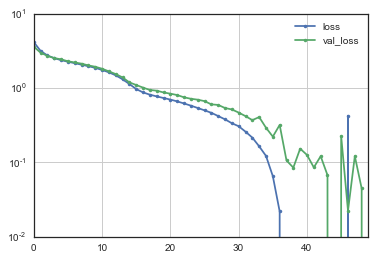

In [20]:
%matplotlib inline
h = pandas.DataFrame(out.history)
h[['loss', 'val_loss']].plot(logy=True, style='.-')
grid()

In [21]:
params = model_gmm.predict(X_train)
p = params

In [22]:
def get_params(params, M, D):
    mu = params[:M * D]
    sigma = params[M * D:(M * D + M)]
    alpha = params[M * D + M:]
    return mu, sigma, alpha
    
def gmm_pdf(y, params, M, D):
    mu = params[:M * D]
    sigma = params[M * D:(M * D + M)]
    alpha = params[M * D + M:]
    p = 0
    for i in range(M):
        p += alpha[i] * exp(- 0.5 * (y - mu[D * i:D * (i + 1)].squeeze()) ** 2 / (sigma[i] ** 2)) / np.sqrt(2 * np.pi*  sigma[i] ** 2)
    return p

mu, sigma, alpha = get_params(p[0,:], M, D)
print(alpha.sum())
gmm_pdf(y_train[0], p[0,:], M, D)

0.999999991036


array([ 0.62867063])

In [23]:
N = 100
yl = linspace(0, 10, N)
i = 0

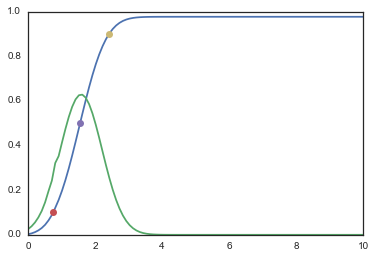

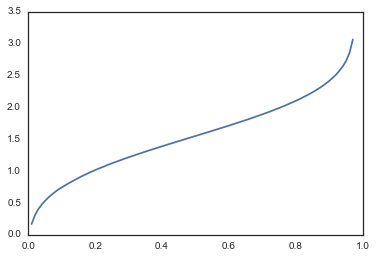

In [24]:
out = gmm_pdf(yl, p[i,:], M, D)
cdf = cumsum(gmm_pdf(yl, p[i,:], M, D)) * (yl.max() - yl.min()) / N
pp = linspace(0, 1, cdf.shape[0])
plot(yl, cdf)
plot(yl, gmm_pdf(yl, p[i,:], M, D))

import scipy.interpolate as si
def get_q(cdf, y):
    return si.interp1d(cdf, y, assume_sorted=True, bounds_error=False)
f = get_q(cdf, yl)
for k in [0.1, 0.5, 0.9]:
    plot(f(k), k, 'o')

figure()
plot(pp, f(pp))

In [25]:
N = 100
yl = linspace(1, 10, N)
yp = []
for i in range(X_train.shape[0]):
    p = params[i,:]
    pdf = gmm_pdf(yl, p, M, D)
    cdf = cumsum(pdf) * (yl.max() - yl.min()) / N
    q = get_q(cdf, yl)
    yp.append([q(k) for k in [0.1, 0.5, 0.9]])
yp = np.array(yp)
y_train.shape, yp.shape    

((135, 1), (135, 3))

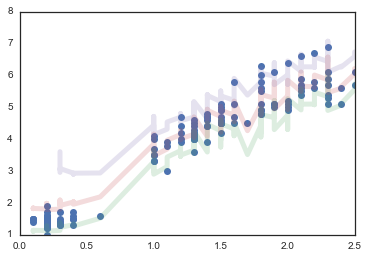

In [26]:
%matplotlib inline
i = 0
x = X_train[:,i]
plot(x, y_train, 'o')
ii = x.argsort()
plot(x[ii], yp[ii], '-', alpha=0.2, linewidth=5)

In [ ]:
yp